In [1]:
import os 
os.environ["JAX_PLATFORMS"]="cpu"

import jax
jax.config.update("jax_enable_x64", True)

import os, sys
import matplotlib.pyplot as plt
from timeit import timeit
from scipy.special import legendre
import numpy as np
import jax.numpy as jnp
from jax import grad, jit
from classy import Class
from pybird.correlator import Correlator
from jax import jacfwd, jacrev
import importlib 
import pybird 
from scipy.interpolate import interp1d
import jax.numpy as jnp
from train_pybird_emulators.emu_utils import emu_utils
from train_pybird_emulators.emu_utils.emu_utils import get_pgg_from_linps_and_f_and_A
from train_pybird_emulators.emu_utils.emu_utils import get_pgg_from_params

In [2]:
resum = True
km=1.0
kr=1.0
nd=3e-4

In [3]:
#set up a baseline cosmology
k_r = 0.7
k_l = 1e-4
# z = .57
z = 0.57

kk = np.logspace(np.log10(k_l), np.log10(k_r), 1000)
M = Class()
cosmo = {'omega_b': 0.02235, 'omega_cdm': 0.120, 'h': 0.675, 'ln10^{10}A_s': 3.044, 'n_s': 0.965}
M.set(cosmo)
M.set({'output': 'mPk', 'P_k_max_h/Mpc': 10, 'z_max_pk': z})
M.compute()
pk_lin = np.array([M.pk_lin(k*M.h(), z)*M.h()**3 for k in kk]) # k in Mpc/h, pk in (Mpc/h)^3

ipk_lin = interp1d(kk, pk_lin, kind='cubic')
D1, f1 = M.scale_independent_growth_factor(z), M.scale_independent_growth_factor_f(z), 
A_s, Omega0_m = 1e-10 * np.exp(cosmo['ln10^{10}A_s']), M.Omega0_m()

### Need to check some of the comsologies in the bank to see whats happening - how can it be bad for the mean cosmo??
* Also make sure the way the parameters are extracted matches what happens in the emulator code!!

In [4]:
# outdir = os.path.join(os.path.expanduser('~'), 'Documents', 'local_software', 'pybird_emu', 'data', 'eftboss', 'out')
outdir = "/cluster/work/refregier/alexree/local_packages/pybird_emu/data/eftboss/out"
with open(os.path.join(outdir, 'fit_boss_onesky_pk_wc_cmass_ngc_l0.dat')) as f: data_file = f.read()
eft_params_str = data_file.split(', \n')[1].replace("# ", "")
eft_params = {key: float(value) for key, value in (pair.split(': ') for pair in eft_params_str.split(', '))}

In [5]:
N_bird = Correlator()
N_bird.set({'output': 'bPk', 'multipole': 3, 'kmax': 0.4,
       'fftaccboost': 2, # boosting the FFTLog precision (slower, but ~0.1% more precise -> let's emulate this)
       'with_resum': resum, 'with_exact_time': True,
       "with_time":False, # test without specifying this too 
       'km': km, 'kr': kr, 'nd': nd,
       'eft_basis': 'eftoflss', 'with_stoch': True})

N_bird.compute({'kk': kk, 'pk_lin': pk_lin, 'D': D1, 'f': f1, 'z': z, 'Omega0_m': Omega0_m},
          do_core=True, do_survey_specific=True)
bpk_benchmark = N_bird.get(eft_params)

loading matrices!
setting EdS time approximation


### Now lets use the training data function to get the pieces for training 

In [6]:
N = Correlator()
# Set up pybird in time unspecified mode for the computation of the pybird pieces training data
N.set(
    {
        "output": "bPk",
        "multipole": 3,
        "kmax": 0.4, #new kmax so dont have to filter out the large ks! 
        "fftaccboost": 2,
        "with_resum": True,
        "with_exact_time": True,
        "with_time": False,  # time unspecified
        "km": 1.0,
        "kr": 1.0,
        "nd": 3e-4,
        "eft_basis": "eftoflss",
        "with_stoch": True,
    }
)

loading matrices!


In [7]:
pk_max = np.amax(pk_lin)
pk_norm = pk_lin/pk_max

In [8]:
outputs = get_pgg_from_linps_and_f_and_A(pk_norm, kk=kk, N=N, f=f1, A=pk_max)

setting EdS time approximation


In [9]:
N_bird.bird.fullIRPsloop[0][0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.11113569,  0.1323971 ,
        0.15273494,  0.1722962 ,  0.19544902,  0.23621874,  0.26443778,
        0.26410186,  0.23882394,  0.23375992,  0.30719569,  0.47349043,
        0.68365529,  0.82989979,  0.82228543,  0.60826244,  0.20109917,
       -0.32447964, -0.8589755 , -1.24991747, -1.35464339, -1.10132334,
       -0.51272255,  0.25832506,  0.96187001,  1.34806766,  1.24533783,
        0.60615157, -0.47283464, -1.7654632 , -2.96823362, -3.78260695,
       -4.003683  , -3.57938162, -2.62204433, -1.38078518, -0.18488588,
        0.63916521,  0.86209484,  0.4212993 , -0.56814817, -1.8621165 ,
       -3.165399  , -4.20458251, -4.77972157, -4.79628985, -4.28115959,
       -3.37886399, -2.32122536, -1.37122699, -0.75517768, -0.60518987,
       -0.93083437, -1.62689045, -2.51068818, -3.37415925, -4.03457213,
       -4.37213229, -4.34868668, -3.45368708, -2.28171793, -1.81

In [10]:
N = Correlator()
# Set up pybird in time unspecified mode for the computation of the pybird pieces training data
N.set(
    {
        "output": "bPk",
        "multipole": 3,
        "kmax": 0.4, #new kmax so dont have to filter out the large ks! 
        "fftaccboost": 2,
        "with_resum": False, # add resum in by hand below 
        "with_exact_time": True,
        "with_time": False,  # time unspecified

        # "with_time": False,  # time unspecified
        "km": 1.0,
        "kr": 1.0,
        "nd": 3e-4,
        "eft_basis": "eftoflss",
        "with_stoch": True,
    }
)

loading matrices!


In [11]:
N.compute({'kk': kk, 'pk_lin': pk_lin, 'D': D1, 'f': f1, 'z': z, 'Omega0_m': Omega0_m},
          do_core=True, do_survey_specific=True)


setting EdS time approximation


In [12]:
shape_ploop = (3, 35, -1)
shape_3 = (3, 3, -1)
shape_6 = (3, 6, -1)
shape_35 = (3, 35, -1)

In [13]:
N.bird.Ploopl[0][0]

array([0.00000000e+00, 8.18401096e-03, 7.64817663e-02, 2.48822805e-01,
       5.28526863e-01, 8.89894176e-01, 1.29804535e+00, 1.72369200e+00,
       2.15162298e+00, 2.58270873e+00, 3.02935344e+00, 3.51088778e+00,
       4.04515244e+00, 5.30963876e+00, 6.79520208e+00, 8.31222585e+00,
       9.60361779e+00, 1.04488073e+01, 1.07860062e+01, 1.07729680e+01,
       1.07481406e+01, 1.11129243e+01, 1.21697448e+01, 1.39847737e+01,
       1.63596108e+01, 1.88886199e+01, 2.10936040e+01, 2.25680688e+01,
       2.30788505e+01, 2.26477998e+01, 2.15287341e+01, 2.01850558e+01,
       1.91481940e+01, 1.88693488e+01, 1.95926228e+01, 2.12602829e+01,
       2.35517905e+01, 2.59930907e+01, 2.80815362e+01, 2.94249692e+01,
       2.98192107e+01, 2.92804409e+01, 2.80354546e+01, 2.64535771e+01,
       2.49788958e+01, 2.40373358e+01, 2.38995847e+01, 2.45898425e+01,
       2.59112915e+01, 2.75377171e+01, 2.91115925e+01, 3.03277312e+01,
       3.09782309e+01, 3.09711670e+01, 3.03612457e+01, 2.93370703e+01,
      

In [14]:
N.bird.P11l += outputs[3].reshape(shape_3)*pk_max
N.bird.Pctl += outputs[4].reshape(shape_6)*pk_max
N.bird.Ploopl += outputs[5].reshape(shape_35)*pk_max**2



In [15]:
N_bird.bird.Ploopl[0][0]

array([0.00000000e+00, 8.18401096e-03, 7.64817663e-02, 2.48822805e-01,
       5.28526863e-01, 8.89894176e-01, 1.29804535e+00, 1.72369200e+00,
       2.26275867e+00, 2.71510583e+00, 3.18208838e+00, 3.68318397e+00,
       4.24060146e+00, 5.54585750e+00, 7.05963986e+00, 8.57632771e+00,
       9.84244173e+00, 1.06825672e+01, 1.10932019e+01, 1.12464584e+01,
       1.14317959e+01, 1.19428241e+01, 1.29920302e+01, 1.45930362e+01,
       1.65607099e+01, 1.85641402e+01, 2.02346285e+01, 2.13181513e+01,
       2.17242071e+01, 2.15464764e+01, 2.10160116e+01, 2.04433808e+01,
       2.01100640e+01, 2.02174164e+01, 2.08379606e+01, 2.18664344e+01,
       2.30789558e+01, 2.42276274e+01, 2.51133025e+01, 2.56423622e+01,
       2.58155277e+01, 2.57010593e+01, 2.54134103e+01, 2.50727920e+01,
       2.47940100e+01, 2.46765010e+01, 2.47616795e+01, 2.50111418e+01,
       2.53431433e+01, 2.56756006e+01, 2.59461935e+01, 2.61231487e+01,
       2.61985093e+01, 2.61748772e+01, 2.60800862e+01, 2.59582063e+01,
      

In [16]:
N.bird.Ploopl[0][0]

array([0.00000000e+00, 8.18401096e-03, 7.64817663e-02, 2.48822805e-01,
       5.28526863e-01, 8.89894176e-01, 1.29804535e+00, 1.72369200e+00,
       2.26275866e+00, 2.71510583e+00, 3.18208837e+00, 3.68318397e+00,
       4.24060147e+00, 5.54585750e+00, 7.05963988e+00, 8.57632772e+00,
       9.84244171e+00, 1.06825672e+01, 1.10932019e+01, 1.12464584e+01,
       1.14317958e+01, 1.19428241e+01, 1.29920301e+01, 1.45930362e+01,
       1.65607099e+01, 1.85641402e+01, 2.02346286e+01, 2.13181514e+01,
       2.17242072e+01, 2.15464764e+01, 2.10160116e+01, 2.04433808e+01,
       2.01100640e+01, 2.02174164e+01, 2.08379605e+01, 2.18664344e+01,
       2.30789559e+01, 2.42276274e+01, 2.51133026e+01, 2.56423623e+01,
       2.58155281e+01, 2.57010592e+01, 2.54134103e+01, 2.50727919e+01,
       2.47940100e+01, 2.46765010e+01, 2.47616795e+01, 2.50111418e+01,
       2.53431433e+01, 2.56756006e+01, 2.59461937e+01, 2.61231490e+01,
       2.61985096e+01, 2.61748771e+01, 2.60800863e+01, 2.59582065e+01,
      

In [17]:
bpk_recovered = N.get(eft_params)

In [18]:
bpk_recovered[0]

array([15546.046221  , 28993.75035143, 46185.86793839, 58082.52279579,
       65881.49495249, 70488.65051879, 72600.00336628, 72776.81899798,
       71490.86794325, 69161.98604965, 66141.81918763, 62716.12714569,
       59135.62542325, 52215.70013339, 46306.33825128, 41719.50960795,
       38344.24285887, 35878.68964958, 33942.9413469 , 32188.33431652,
       30375.40886   , 28402.58339994, 26300.3789604 , 24187.81631782,
       22207.10263008, 20474.62430832, 19049.62263196, 17931.2628911 ,
       17073.66628971, 16402.78624176, 15838.58104249, 15307.51271103,
       14758.58642631, 14170.28562261, 13547.85160636, 12915.82377003,
       12305.31349629, 11743.5930313 , 11248.16710823, 10824.55905023,
       10467.198787  , 10162.53819185,  9893.61656818,  9644.31707616,
        9401.58590072,  9157.09177657,  8909.03174863,  8660.2576904 ,
        8416.23929478,  8183.03902622,  7964.90017319,  7764.04224352,
        7580.68929687,  7412.88420696,  7258.35059029,  7114.12091841,
      

In [19]:
bpk_benchmark[0]

array([15546.046221  , 28993.75035143, 46185.86793839, 58082.52279579,
       65881.49495249, 70488.65051879, 72600.00336628, 72776.81899798,
       71490.86794244, 69161.98604974, 66141.81918792, 62716.12714561,
       59135.62542268, 52215.700134  , 46306.33825182, 41719.50961135,
       38344.24286072, 35878.68965429, 33942.94135185, 32188.3343158 ,
       30375.4088634 , 28402.58340531, 26300.37895861, 24187.81632006,
       22207.10262679, 20474.62430499, 19049.62262982, 17931.26288073,
       17073.66628487, 16402.78624676, 15838.58103711, 15307.51271498,
       14758.58642903, 14170.28562495, 13547.85161288, 12915.8237636 ,
       12305.31349687, 11743.59303126, 11248.16710648, 10824.55905025,
       10467.19877955, 10162.53818819,  9893.61656739,  9644.31707473,
        9401.58589957,  9157.09177849,  8909.03174887,  8660.25769015,
        8416.23930183,  8183.03903111,  7964.90017202,  7764.04223428,
        7580.68928829,  7412.88420152,  7258.35059084,  7114.12091688,
      

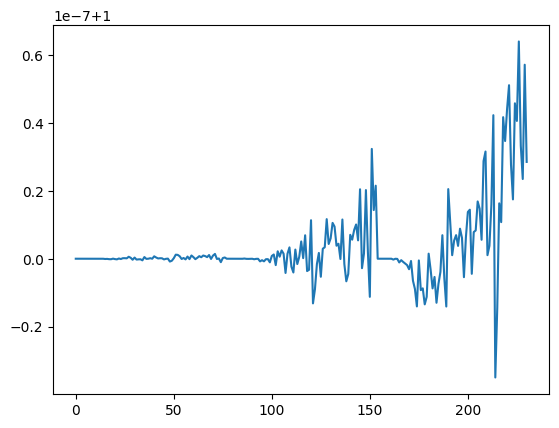

In [20]:
plt.plot(bpk_recovered.flatten()[:]/bpk_benchmark.flatten()[:])

### Next lets test this with the decomposition algorithm as well 

In [21]:
N = Correlator()
# Set up pybird in time unspecified mode for the computation of the pybird pieces training data
N.set(
    {
        "output": "bPk",
        "multipole": 3,
        "kmax": 0.4, #new kmax so dont have to filter out the large ks! 
        "fftaccboost": 2,
        "with_resum": True, # needed for the computation  
        "with_exact_time": True,
        "with_time": False,  # time unspecified

        # "with_time": False,  # time unspecified
        "km": 1.0,
        "kr": 1.0,
        "nd": 3e-4,
        "eft_basis": "eftoflss",
        "with_stoch": True,
    }
)

loading matrices!


In [22]:
N.compute({'kk': kk, 'pk_lin': pk_lin, 'D': D1, 'f': f1, 'z': z, 'Omega0_m': Omega0_m},
          do_core=True, do_survey_specific=True)

setting EdS time approximation


In [23]:
filename_config = "/cluster/work/refregier/alexree/local_packages/train_pybird_emulators/src/train_pybird_emulators/configs/config_pybird_80_knots_5sigma.yaml"
config_loaded = emu_utils.read_yaml_file(filename_config)
parameters_dicts = config_loaded["parameters"]

In [24]:
knots = np.load("/cluster/work/refregier/alexree/local_packages/pybird_emu/data/emu/knots.npy")
# slightly modify the start and end knot to fall in the range of k we are using so that the interpolation does not fail
eps = 1e-10
knots[0] = knots[0] + eps
knots[-1] = knots[-1] - eps
param_realization = [] 
pk_i = 1.*pk_lin
f_i = 1.*f1
#Get the spline params
ilogpk = interp1d(np.log(kk), np.log(pk_norm), kind = 'cubic')
spline_params = emu_utils.get_spline_params(knots,ilogpk)
param_realization.extend(list(spline_params))
param_realization.append(pk_max)
param_realization.append(f_i)
emu_inputs_i = np.array(param_realization)

In [ ]:
outputs_params = get_pgg_from_params(emu_inputs_i, parameters_dicts, N, kk, knots)

setting EdS time approximation


In [ ]:
N = Correlator()
# Set up pybird in time unspecified mode for the computation of the pybird pieces training data
N.set(
    {
        "output": "bPk",
        "multipole": 3,
        "kmax": 0.4, #new kmax so dont have to filter out the large ks! 
        "fftaccboost": 2,
        "with_resum": False, # add by hand below 
        "with_exact_time": True,
        "with_time": False,  # time unspecified

        # "with_time": False,  # time unspecified
        "km": 1.0,
        "kr": 1.0,
        "nd": 3e-4,
        "eft_basis": "eftoflss",
        "with_stoch": True,
    }
)

N.compute({'kk': kk, 'pk_lin': pk_lin, 'D': D1, 'f': f1, 'z': z, 'Omega0_m': Omega0_m},
          do_core=True, do_survey_specific=True)

In [ ]:
N.bird.P11l += outputs_params[3].reshape(shape_3)*pk_max
N.bird.Pctl += outputs_params[4].reshape(shape_6)*pk_max
N.bird.Ploopl = outputs_params[2].reshape(shape_ploop)*pk_max**2 + outputs[5].reshape(shape_35)*pk_max**2

In [ ]:
bpk_recovered2 = N.get(eft_params)

In [ ]:
plt.plot(bpk_recovered2.flatten()/bpk_benchmark.flatten())

### Good now lets try to understand where the emulator goes wrong here

In [ ]:
from pybird import config
config.set_jax_enabled(True) # Enable JAX by setting the config Class
import jax.numpy as jnp 

In [ ]:
N_emu = Correlator()
# Set up pybird in time unspecified mode for the computation of the pybird pieces training data
N_emu.set(
    {
        "output": "bPk",
        "multipole": 3,
        "kmax": 0.4, #new kmax so dont have to filter out the large ks! 
        "fftaccboost": 2,
        "with_resum": True, # add resum in by hand below 
        "with_exact_time": True,
        "with_time": False,  # time unspecified
        "with_emu":True,
        # "with_time": False,  # time unspecified
        "km": 1.0,
        "kr": 1.0,
        "nd": 3e-4,
        "eft_basis": "eftoflss",
        "with_stoch": True,
    }
)

In [ ]:
N_emu.compute({'kk': jnp.array(kk), 'pk_lin': jnp.array(pk_lin), 'D': D1, 'f': f1, 'z': jnp.array(z), 'Omega0_m': Omega0_m},
          do_core=True, do_survey_specific=True)

In [ ]:
bpk_recovered_emu = N_emu.get(eft_params)

In [ ]:
plt.plot(bpk_recovered_emu.flatten()[0:77]/bpk_benchmark.flatten()[:77])

In [ ]:
plt.plot(N.bird.Ploopl[0][1])
plt.plot(N_emu.bird.Ploopl[0][1],'r--')


### How representative is this training data really 

In [ ]:
import h5py

database = "/cluster/scratch/areeves/pk_bank_boss_gaussian_cov_fixed_bug2/total_data.h5"
# database = "/cluster/work/refregier/alexree/local_packages/train_pybird_emulators/src/train_pybird_emulators/notebooks/merged_output2.h5"

with h5py.File(database, "r") as f: 
    print(f.keys())
    pk_lin_array = f["pk_lin"][:]
    kk = f["kk"][:]

In [ ]:
kk = kk[:1000]

In [ ]:
fig, ax = plt.subplots()

for i in range(5000):
    plt.loglog(kk, pk_lin_array[i]/np.amax(pk_lin_array[i]), 'b--', alpha=0.01)

plt.loglog(kk, pk_lin/np.amax(pk_lin), lw=1)

### Here is the issue: N_ur us causing all of the equality scales to be much earlier? 

In [ ]:
M = Class()
cosmo = {'omega_b': 0.02235, 'omega_cdm': 0.120, 'h': 0.675, 'ln10^{10}A_s': 3.044, 'n_s': 0.965}
M.set(cosmo)
M.set({'output': 'mPk', 'P_k_max_h/Mpc': 10, 'z_max_pk': z})
M.compute()
pk_lin = np.array([M.pk_lin(k*M.h(), z)*M.h()**3 for k in kk]) # k in Mpc/h, pk in (Mpc/h)^3

In [ ]:
M.Omega_m()

In [ ]:
# params = {'omega_b': 0.02235, 'omega_m': 0.315, 'h': 0.675, 'ln10^{10}A_s': 3.044, 'n_s': 0.965,} #'Omega_k': 0.,} #'m_ncdm': 0.02, 'N_ur': 0.00641}

params = {'omega_b': 0.02235, 'Omega_m':0.3124279835390946, 'h': 0.675, 'ln10^{10}A_s': 3.044, 'n_s': 0.965, 'Omega_k': 0., 'm_ncdm': 0.02, 'N_ur': 0.00641}

# params = {'omega_b': 0.02235, 'omega_cdm': 0.120, 'h': 0.675, 'ln10^{10}A_s': 3.044, 'n_s': 0.965,} #'Omega_k': 0.,} #'m_ncdm': 0.02, 'N_ur': 0.00641}


In [ ]:
cosmo = Class()
#set the parameters
cosmo.set(params)
#compute the power spectrum
cosmo.set({"output":"mPk", 
            "N_ncdm": 1,
            "deg_ncdm": 3, #3 degenerate neutrino mass specied
           "P_k_max_1/Mpc": 10.,
           'z_max_pk': z})
cosmo.compute()
pk_lin_mean = np.array([cosmo.pk_lin(k*cosmo.h(), z)*cosmo.h()**3 for k in kk]) # k in Mpc/h, pk in (Mpc/h)^3


In [ ]:
cosmo.Omega_Lambda()

In [ ]:
M.Omega_Lambda()

In [ ]:
plt.loglog(kk, pk_lin_mean/np.amax(pk_lin_mean), 'r')
plt.loglog(kk, pk_lin/np.amax(pk_lin))